Approximation to continuous POMDP implemented using `github.com/JuliaPOMDP/QuickPOMDPs.jl` and solved using POMCP with reference to tutorial [here](https://htmlview.glitch.me/?https://github.com/JuliaAcademy/Decision-Making-Under-Uncertainty/blob/master/html/4-Approximate-Methods.jl.html).

In [2]:
pr = [1, 3, 5]
mr = [4, 4, 5]
pr./mr

3-element Vector{Float64}:
 0.25
 0.75
 1.0

In [1]:
using POMDPs, QuickPOMDPs, POMDPModelTools, POMDPPolicies, Parameters, Random, Plots, LinearAlgebra, Serialization
using POMDPTools, BasicPOMCP, D3Trees, GridInterpolations, POMCPOW, POMDPModels, Combinatorics, Dates, CSV, ParticleFilters

In [2]:
expID = Dates.format(Dates.now(), "yymd_HHMMS")

"2333_140736"

In [3]:
function log(s::String)
    s_time = Dates.format(Dates.now(), "HH:MM:SS\t")*s*"\n"
    open("./logs/"*expID*".txt", "a") do file
        write(file, s_time)
    end
    print(s_time)
end

log (generic function with 1 method)

In [4]:
log("Running experiment with ID "*expID)

14:07:36	Running experiment with ID 2333_140736


# Define Problem

In [5]:
@with_kw struct MyParameters
    N::Int = 3         # size of item set
    K::Int = 3         # size of arm set
    M::Int = 3        # size of beta set
    y::Real = 0.999     # discount factor
    umax::Real = 10    # max utility
    u_grain:: Int = 3  # granularity of utility approximation
    d_grain:: Int = 3  # granularity of arm distribution approximation
    beta:: Array{Float64} = [0, 0.01, 50.0]  # teacher beta values
end

params = MyParameters()
log(string(params))

14:07:37	MyParameters
  N: Int64 3
  K: Int64 3
  M: Int64 3
  y: Float64 0.999
  umax: Int64 10
  u_grain: Int64 3
  d_grain: Int64 3
  beta: Array{Float64}((3,)) [0.0, 0.01, 50.0]



# Create POMDP

In [6]:
struct State
    u::Array{Float64}         # list of N utility values for N items
    d::Array{Array{Float64}}  # list of K arm distributions, each assigning probabilities to N items
    b::Array{Float64}         # list of M beta values
end

In [7]:
# space of utility functions
@time begin
    umin = 0
    grid_coor = fill(range(umin,params.umax,length=params.u_grain), params.N)
    U = RectangleGrid(grid_coor...)
end

@assert length(U[1]) == params.N
log("generated "*string(length(U))*" utilities (each length "*string(length(U[1]))*" items)")

  0.143240 seconds (163.60 k allocations: 8.391 MiB, 99.50% compilation time)
14:07:37	generated 27 utilities (each length 3 items)


In [8]:
function generate_probability_distributions(N::Int, coor::Array{Float64}, S::Float64=1.0)
    if S == 0
        return [[0. for _ in 1:N]]
    end
    if N == 1
        return [[float(S)]]
    end
    out = []
    range = coor[1:findall(x->isapprox(x,S,atol=1e-15), coor)[1]]
    for k in range
        subsolution = generate_probability_distributions(N-1, coor, S-k)
        for lst in subsolution
            if typeof(lst[1]) != Float64
                log("ERROR: lst "*string(lst)*" has type "*string(typeof(lst[1]))*". Must be Float64.")
            end
            prepend!(lst, float(k))
        end
        out = vcat(out, subsolution)
    end
    return out
end

generate_probability_distributions (generic function with 2 methods)

In [9]:
# space of arm distributions
@time begin
    coor = collect(range(0.,1.,length=params.d_grain))    
    simplex_list = generate_probability_distributions(params.N, coor)
    D_tuples = vec(collect(Base.product(fill(simplex_list, params.K)...)))
    D = [collect(d) for d in D_tuples]
end

@assert length(D[1]) == params.K
@assert length(D[1][1]) == params.N
log(string("generated "*string(length(D))*" arm distribution sets (each shape "*string(length(D[1]))*" arms x "*string(length(D[1][1]))*" items)"))
    
    

  0.296923 seconds (1.59 M allocations: 81.502 MiB, 4.08% gc time, 98.94% compilation time)
14:07:38	generated 216 arm distribution sets (each shape 3 arms x 3 items)


In [10]:
# beta values
B = [params.beta]

# each beta value set must be length M
@assert length(B[1]) == params.M
log(string("generated "*string(length(B))*" beta value sets (each length "*string(length(B[1]))*" teachers)"))

14:07:38	generated 1 beta value sets (each length 3 teachers)


In [11]:
# State space
@time begin     
    S = [[State(u,d,b) for u in U, d in D, b in B]...,]
end

log("generated "*string(length(S))*" states")

  0.101615 seconds (747.86 k allocations: 38.895 MiB, 98.28% compilation time)
14:07:38	generated 5832 states


In [12]:
function interesting(s::State)
    e = [dot(s.u, di) for di in s.d]
    order = e[1] > e[2] && e[2] >= e[3] 
    diff = s.d[1] != s.d[2] != s.d[3]
    stoch = all([s.d[i][j]!=1. for i in 1:3, j in 1:3])
    return order && stoch && diff
end

to_print = false
indices = []
for i in 1:length(S)
    if interesting(S[i])
        if to_print
            println("index ", i)
            println(S[i])
        end
        push!(indices, i)
    end
end

# length(indices)/length(S)
rand(indices, 10)

10-element Vector{Any}:
 3617
 4152
 4427
 3191
 1712
 4426
 4151
 1713
 3195
 3617

In [101]:
function print_state(s::State)
    println("\t u: ", s.u)
    println("\t d1: ", s.d[1], "\t (exp val ", dot(s.u, s.d[1]), ")")
    println("\t d1: ", s.d[2], "\t (exp val ", dot(s.u, s.d[2]), ")")
    println("\t d1: ", s.d[3], "\t (exp val ", dot(s.u, s.d[3]), ")")
end

state_IDs = [12]

for ID in state_IDs
    println("\nState ", ID, ":")
    print_state(S[ID])
end


State 12:
	 u: [10.0, 0.0, 5.0]
	 d1: [0.0, 0.0, 1.0]	 (exp val 5.0)
	 d1: [0.0, 0.0, 1.0]	 (exp val 5.0)
	 d1: [0.0, 0.0, 1.0]	 (exp val 5.0)


State([10.0, 0.0, 5.0], Array{Float64}[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0]], [0.0, 0.01, 50.0])

3-element Vector{SubString{String}}:
 "State([10.0, 0.0, 5.0], Array"
 "Float64"
 "[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0]], [0.0, 0.01, 50.0])"

In [14]:
# Action space - actions are arm choices (K) or beta selections (M)
struct Action
    name::String      # valid names are {B,C} + index
    isBeta::Bool      # true if 'B' action, false if 'C' action
    index::Integer    # index of beta (if 'B' action) or arm choice (if 'C' action)
end

A = Array{Action}(undef, params.K+params.M)
for i in 1:params.K+params.M
    if i <= params.K
        A[i] = Action("C"*string(i), false, i)
    else
        A[i] = Action("B"*string(i-params.K), true, i-params.K)
    end
end
log("generated "*string(length(A))*" actions")

14:07:39	generated 6 actions


In [15]:
# Transition function
function T(s::State, a::Action)
    return SparseCat([s], [1.0])    # categorical distribution
end
log("generated transition function")

14:07:39	generated transition function


In [16]:
# Reward function
function R(s::State, a::Action)
    # if beta selected, return 0
    if a.isBeta
        return 0
    # if arm pulled, return that arm's avg utility
    else
        utilities = s.u
        arm_dist = s.d[a.index]
        return dot(utilities, arm_dist)
    end
end
log("generated reward function")

14:07:39	generated reward function


In [17]:
# item space
I = 1:params.N

# preference space
struct Preference
    i0::Int    # first item to compare, in {1,2,...,N}
    i1::Int    # second item to compare, in {1,2,...,N}
    label::Int # feedback label, in {0,1}
end

P = [[Preference(i0,i1,label) for i0 in I, i1 in I, label in [0,1]]...,]

# observation space
struct Observation
    isItem::Bool    # true if item returned, false otherwise
    i::Int          # item, if item returned
    p::Preference   # preference, if preference returned
end

invalid_i = -1
invalid_p = Preference(-1,-1,-1)
I_obs = [Observation(true, i, invalid_p) for i in I]
P_obs = [Observation(false, invalid_i, p) for p in P]
omega = union(I_obs, P_obs)

log("generated "*string(length(omega))*" observations")

14:07:39	generated 21 observations


In [18]:
# unnormalized query profile (likelihood of querying 1,1; 2,1; 3,1; ... ; N,1; 1,2; 2,2; ... ; N,N)
Q = [o.p.i0 != o.p.i1 for o in P_obs]

# preference probability (expected preference, or probability that preference=1)
function Pr(p::Preference, s::State, b::Float64)
    prob_pref_1 = exp(Float64(b)*s.u[p.i1])/(exp(Float64(b)*s.u[p.i1])+exp(Float64(b)*s.u[p.i0]))
    if p.label == 1
        return prob_pref_1
    else
        return 1.0-prob_pref_1
    end
end

Pr (generic function with 1 method)

In [19]:
function O(s::State, a::Action, sp::State)
    # if B action, obs in P_obs
    if a.isBeta
        prob_of_pref = [Pr(o.p, s, s.b[a.index]) for o in P_obs]
        prob_of_query = Q 
        
        # weight by querying profile to get dist
        dist = [prob_of_pref[i]*prob_of_query[i] for i in 1:length(prob_of_pref)]
        normalized_dist = dist/sum(dist)        
        return SparseCat(P_obs, normalized_dist)
    # if C action, obs in I_obs
    else
        return SparseCat(I_obs, s.d[a.index])
    end
end

log("generated observation function")

14:07:39	generated observation function


In [20]:
@time begin
    
    # define POMDP
    abstract type MyPOMDP <: POMDP{State, Action, Observation} end
    pomdp = QuickPOMDP(MyPOMDP,
        states       = S,
        actions      = A,
        observations = omega,
        transition   = T,
        observation  = O,
        reward       = R,
        discount     = params.y,
        initialstate = S);

end

log("created POMDP")

  0.546339 seconds (2.32 M allocations: 125.522 MiB, 4.44% gc time, 99.14% compilation time)
14:07:40	created POMDP


# Solve POMDP

In [93]:
@time begin
    solver = POMCPOWSolver(max_depth=1)
    planner = solve(solver, pomdp);
end
log("solved POMDP")

open("./policies/"*expID*"_policy.txt", "w") do file
    serialize(file, planner)
end

log("saved policy to "*"./policies/"*expID*"_policy.txt")

  0.000015 seconds (12 allocations: 784 bytes)
14:44:12	solved POMDP
14:44:12	saved policy to ./policies/2333_140736_policy.txt


In [94]:
action(planner, Uniform(S))

Action("C3", false, 3)

In [95]:
rollout = true

if rollout
    show_state = true
    for (s,a,r,o) in stepthrough(pomdp, planner, "s,a,r,o", max_steps=3)
        if show_state
            @show s
            println("")
            show_state = false
        end
        @show a
        @show r
        @show o
        println()
    end
end

s = State([0.0, 10.0, 10.0], Array{Float64}[[0.5, 0.0, 0.5], [0.0, 1.0, 0.0], [0.5, 0.5, 0.0]], [0.0, 0.01, 50.0])

a = Action("C2", false, 2)
r = 10.0
o = Observation(true, 2, Preference(-1, -1, -1))

a = Action("C2", false, 2)
r = 10.0
o = Observation(true, 2, Preference(-1, -1, -1))

a = Action("C3", false, 3)
r = 5.0
o = Observation(true, 1, Preference(-1, -1, -1))



# Evaluate Solution

In [96]:
# worst 3 states
worst_states = [4641, 4589, 3204]

3-element Vector{Int64}:
 4641
 4589
 3204

In [97]:
steps = 100
iters = 10

# initial_states = [State([0.0, 8.0, 10.0], Array{Float64}[[0.0, 0.0, 1.0], [0.6, 0.0, 0.4], [1.0, 0.0, 0.0]], [0.01, 10.0]) for i in 1:iters]
initial_states = [S[worst_states[1]] for _ in 1:iters]
POMCPOW_R = Array{Float64}(undef, iters)
beliefs = Array{Array{ParticleFilters.ParticleCollection{State}}}(undef, (iters, steps))
@time begin
    for iter in 1:iters
        log("running simulation "*string(iter))
        log("state "*string(initial_states[iter]))

        t = 1
        r_accum = 0.
        beliefs_iter = Array{ParticleFilters.ParticleCollection{State}}(undef, steps)
        for (s, a, o, r, b) in stepthrough(pomdp, planner, updater(planner), Uniform(S), initial_states[iter], "s,a,o,r,b", max_steps=steps)
            r_accum = r_accum + r
            beliefs_iter[t] = b
            
            if t%10 == 0
                println(t)
            end

            if t == 1
                open("./sims/"*expID*"_run"*string(iter)*".txt", "w") do file
                    write(file, string(s))
                end
                println(s)
            end

            if a.isBeta
                msg = "\n"*string(t)*",B,"*a.name*",(i"*string(o.p.i0)*"-i"*string(o.p.i1)*";"*string(o.p.label)*"),"*string(r)
            else
                msg = "\n"*string(t)*",C,"*a.name*",i"*string(o.i)*","*string(r)
            end

            open("./sims/"*expID*"_run"*string(iter)*".txt", "a") do file
                write(file, msg)
            end
            t = t + 1
        end
        beliefs[iter] = beliefs_iter
        POMCPOW_R[iter] = r_accum
    end

    log("ran "*string(iters)*" POMCPOW rollouts for "*string(steps)*" timesteps each")
    log("POMCPOW R: "*string(POMCPOW_R))

#     open("./beliefs/"*expID*"_belief.txt", "w") do file
#         serialize(file, beliefs)
#     end

#     log("saved beliefs to "*"./beliefs/"*expID*"_belief.txt")
end

14:44:14	running simulation 1
14:44:14	state State([10.0, 5.0, 10.0], Array{Float64}[[0.5, 0.0, 0.5], [0.5, 0.5, 0.0], [0.5, 0.5, 0.0]], [0.0, 0.01, 50.0])
State([10.0, 5.0, 10.0], Array{Float64}[[0.5, 0.0, 0.5], [0.5, 0.5, 0.0], [0.5, 0.5, 0.0]], [0.0, 0.01, 50.0])
10
20
30
40
50
60
70
80
90
100
14:44:15	running simulation 2
14:44:15	state State([10.0, 5.0, 10.0], Array{Float64}[[0.5, 0.0, 0.5], [0.5, 0.5, 0.0], [0.5, 0.5, 0.0]], [0.0, 0.01, 50.0])
State([10.0, 5.0, 10.0], Array{Float64}[[0.5, 0.0, 0.5], [0.5, 0.5, 0.0], [0.5, 0.5, 0.0]], [0.0, 0.01, 50.0])
10
20
30
40
50
60
70
80
90
100
14:44:15	running simulation 3
14:44:15	state State([10.0, 5.0, 10.0], Array{Float64}[[0.5, 0.0, 0.5], [0.5, 0.5, 0.0], [0.5, 0.5, 0.0]], [0.0, 0.01, 50.0])
State([10.0, 5.0, 10.0], Array{Float64}[[0.5, 0.0, 0.5], [0.5, 0.5, 0.0], [0.5, 0.5, 0.0]], [0.0, 0.01, 50.0])
10
20
30
40
50
60
70
80
90
100
14:44:16	running simulation 4
14:44:16	state State([10.0, 5.0, 10.0], Array{Float64}[[0.5, 0.0, 0.5], [0.5

In [72]:
# new_beliefs = deserialize(open("./beliefs/"*"2299_123850"*"_belief.txt", "r"));

In [73]:
prior = Uniform(S)
sim = RolloutSimulator(max_steps=steps)

random_R = zeros(iters)
for iter in 1:iters
    # use the same initial states as the POMCPOW runs
    initial_state = initial_states[iter]
    up = updater(RandomPolicy(pomdp))
    result = simulate(sim, pomdp, RandomPolicy(pomdp), up, prior, initial_state)
    random_R[iter] = result
end

log("ran "*string(iters)*" random rollouts for "*string(steps)*" timesteps each")
log("Random R: "*string(random_R))


14:26:51	ran 3 random rollouts for 100 timesteps each
14:26:51	Random R: [369.3464620000372, 429.5408652487354, 386.18900646357594]


In [74]:
max_R = zeros(iters)

for iter in 1:iters
    # use the same initial states as the POMCPOW runs
    initial_state = initial_states[iter]
    max_R[iter] = maximum([dot(initial_state.u, initial_state.d[i]) for i in 1:params.K])*steps
end

log("Max R: "*string(max_R))

14:26:51	Max R: [1000.0, 1000.0, 1000.0]


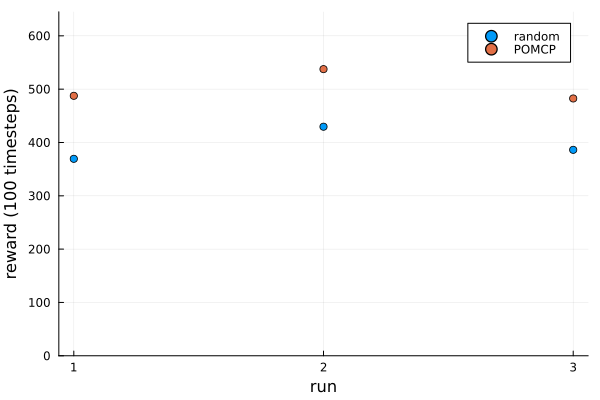

In [75]:
fig = plot(1:iters, [random_R,POMCPOW_R], 
    seriestype = :scatter, 
    label=["random" "POMCP"], 
    xticks = 0:1:iters,
    xlabel = "run",
    ylabel = "reward (" * string(steps) * " timesteps)",
    ylims = (0,maximum(POMCPOW_R)*1.2)
)
# savefig(fig,"./plots/reward_ID"*string(expID)*"_step"*string(steps)*"_roll"*string(iters)*".png")